# Importing libraries and downloading dataset

In [14]:
import glob
import cv2
import torch.nn as nn 
import os
import torch
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision
import torchvision.transforms as transforms 


# Hyperparameters

In [15]:
batch_size = 4

In [16]:
# path = kagglehub.dataset_download("nickj26/places2-mit-dataset") + 'versions/2/test_256/test_256'
train_path = '/home/manjot/.cache/kagglehub/datasets/nickj26/places2-mit-dataset/versions/2/test_256/train'
test_path = '/home/manjot/.cache/kagglehub/datasets/nickj26/places2-mit-dataset/versions/2/test_256/test'
print("Path to dataset files:", train_path)

Path to dataset files: /home/manjot/.cache/kagglehub/datasets/nickj26/places2-mit-dataset/versions/2/test_256/train


## Size of training batch

In [17]:
file_names = glob.glob(train_path + '/*.jpg')

print(len(file_names))
print(file_names[:10])

328168
['/home/manjot/.cache/kagglehub/datasets/nickj26/places2-mit-dataset/versions/2/test_256/train/Places365_test_00067829.jpg', '/home/manjot/.cache/kagglehub/datasets/nickj26/places2-mit-dataset/versions/2/test_256/train/Places365_test_00005034.jpg', '/home/manjot/.cache/kagglehub/datasets/nickj26/places2-mit-dataset/versions/2/test_256/train/Places365_test_00241834.jpg', '/home/manjot/.cache/kagglehub/datasets/nickj26/places2-mit-dataset/versions/2/test_256/train/Places365_test_00017812.jpg', '/home/manjot/.cache/kagglehub/datasets/nickj26/places2-mit-dataset/versions/2/test_256/train/Places365_test_00203406.jpg', '/home/manjot/.cache/kagglehub/datasets/nickj26/places2-mit-dataset/versions/2/test_256/train/Places365_test_00184281.jpg', '/home/manjot/.cache/kagglehub/datasets/nickj26/places2-mit-dataset/versions/2/test_256/train/Places365_test_00317614.jpg', '/home/manjot/.cache/kagglehub/datasets/nickj26/places2-mit-dataset/versions/2/test_256/train/Places365_test_00299825.jpg', 

# Data preprocessing

In [18]:
class Placesdataset(Dataset):
    def __init__(self, dir_path, image_dim=(256,256),n_channels=3, mask_iterations = 7):
        self.file_names = glob.glob(dir_path + '/*.jpg')
        self.img_dim = image_dim
        self.to_tensor = transforms.ToTensor()
        self.channels = n_channels
        self.iterations = mask_iterations
        self.resize = transforms.Resize(image_dim)

    def __getitem__(self, idx):
        image = Image.open(self.file_names[idx]).convert("RGB")
        Y_output = self.resize(image)
        X_input, X_mask = self.create_mask(Y_output)
        X_input = self.to_tensor(X_input)
        X_mask = self.to_tensor(X_mask)
        Y_output = self.to_tensor(Y_output)
        return X_input, X_mask, Y_output

        

    def __len__(self):
        return len(self.file_names)
    
    def line_generator(self, image):
        for _ in range(self.iterations):
            pt1 = (np.random.randint(0,self.img_dim[0]),np.random.randint(0,self.img_dim[1]))
            pt2 = (np.random.randint(0,self.img_dim[0]),np.random.randint(0,self.img_dim[1]))
            thickness =np.random.randint(5, 10)
            
            cv2.line(image, pt1=pt1, pt2=pt2, color=(1,1,1), thickness=thickness)

    def circle_generator(self, image):
        for _ in range(self.iterations):
            pt1 = (np.random.randint(0,self.img_dim[0]),np.random.randint(0,self.img_dim[1]))
            radius =np.random.randint(5, 15)

            cv2.circle(image,pt1,radius,(1,1,1), -1)

    def create_mask(self, image):
        mask = np.full((self.img_dim[0], self.img_dim[1], self.channels), 255, dtype=np.uint8)
        self.line_generator(mask)
        self.circle_generator(mask)

        image = np.asarray(image)
        masked_image = cv2.bitwise_and(image, mask)
        return masked_image, mask

In [19]:
Training_Data = Placesdataset(train_path)

Training_Loader = torch.utils.data.DataLoader(Training_Data, batch_size, shuffle=True)

Train_Iter = iter(Training_Loader)


torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])
Masked Image


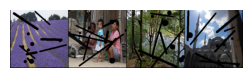

Masking Pattern


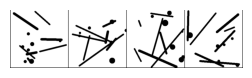

Original Image


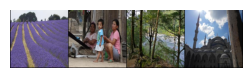

In [20]:
X_in, X_mask, Y_out = Train_Iter._next_data()
print(X_in.shape, X_mask.shape, Y_out.shape)

def imshow_masked(img):
  npimg = img.numpy()
  plt.figure(figsize = (3, 3))
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

print('Masked Image')
imshow_masked(torchvision.utils.make_grid(X_in))
print('Masking Pattern')
imshow_masked(torchvision.utils.make_grid(X_mask))
print('Original Image')
imshow_masked(torchvision.utils.make_grid(Y_out))

# Model Architecture

![Architecture](Places-2-network-architecture.png)

In [21]:
class Partial_Conv(nn.Module):
    def __init__(self, input_filters, output_filters, kernel_size=(3,3), padding=0, stride=1, bias=True, groups=1,dilation=1):
        super().__init__()
        padding = (kernel_size[0]//2, kernel_size[1]//2)
        self.input_conv = nn.Conv2d(input_filters,output_filters,kernel_size,stride,padding,dilation,groups,bias)
        self.mask_conv = nn.Conv2d(input_filters,output_filters,kernel_size,stride,padding,dilation,groups, False)

        self.window_size = kernel_size[0]*kernel_size[1]
        nn.init.constant_(self.mask_conv.weight, 1.0)

        for param in self.mask_conv.parameters():
            param.requires_grad = False
    
    def forward(self, input, mask):
        output = self.input_conv(input * mask)

        with torch.no_grad():
            output_mask = self.mask_conv(mask)

        mask_ratio = self.window_size / (output_mask + 1e-8)
        output_mask = torch.clamp(output_mask, 0, 1)
        mask_ratio = mask_ratio * output_mask
        output = output * mask_ratio

        return output, output_mask